<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 4
<br>
<b>Deadline:</b> April 20, 2020 (Monday). 23:00
</div>

# Exercise 7. Graph neural networks. Recurrent relational network

The goal of this exercise is to get familiar with graph neural networks.

We will implement a simplified version of the recurrent relational network proposed in [this paper](http://papers.nips.cc/paper/7597-recurrent-relational-networks.pdf).

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
# device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

In [7]:
torch.cuda.get_device_name(0)

'GeForce GTX 950M'

In [8]:
device

device(type='cpu')

# Data

The dataset is a set of sudoku puzzles with solutions obtained from [here](https://github.com/locuslab/SATNet).

In [9]:
import data
trainset = data.Sudoku(data_dir, train=True)
testset = data.Sudoku(data_dir, train=False)

x, y = trainset[0]
print(x.shape, y.shape)

torch.Size([81, 9]) torch.Size([81])


In [10]:
x[0,:]
# This is the one-hot encoded version of the input
# x is made of 81 rows (one for every cell in the sudok) and 9 values of the one-hot encoding
# The position of the nonzero value indicates which integer is in that cell

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.])

We can visualize the data in the following way.

In [11]:
def sudoku_to_labels(x):
    """Convert one-hot coded sudoku puzzles to labels. -1 corresponds to missing labels.
    
    Args:
      x of shape (n_rows=9, n_colums=9, n_digits=9): Tensor with a sudoku board. The digits are one-hot coded.
                  Cells with unknown digits have all zeros along the third dimension.
    """
    assert x.shape == torch.Size([9, 9, 9]), "Wrong shape {}".format(x.shape)
    is_filled = x.sum(dim=2)
    y = x.argmax(dim=2)
    y[~is_filled.bool()] = -1
    return y

In [12]:
sudoku_to_labels(x.view(9, 9, 9)).shape
# The one-hot encoding is transformed to integers where each value is in their respective cell.

torch.Size([9, 9])

In [13]:
print(sudoku_to_labels(x.view(9, 9, 9)))

tensor([[ 5,  6, -1, -1, -1, -1, -1, -1,  4],
        [-1, -1,  2, -1,  3, -1, -1,  7,  1],
        [-1,  3, -1, -1, -1,  4,  0,  2,  5],
        [-1, -1, -1,  6,  2, -1, -1,  8, -1],
        [ 2, -1,  3,  1, -1,  5, -1,  6, -1],
        [-1, -1,  0, -1,  8, -1,  5, -1, -1],
        [ 4, -1,  8, -1, -1,  7, -1, -1, -1],
        [-1, -1, -1,  8,  4, -1,  1, -1,  7],
        [-1, -1, -1,  0,  1,  6,  3, -1, -1]])


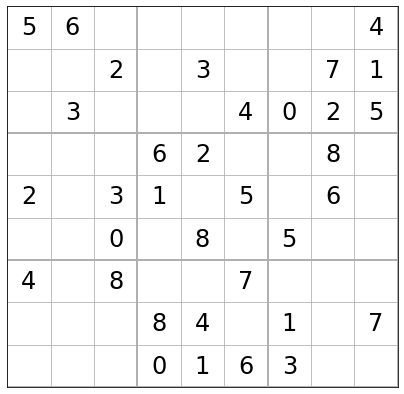

In [14]:
tools.draw_sudoku(x.view(9, 9, 9), logits=False)

## Graph

We describe each sudoku puzzle as a graph in which each node corresponds to one of the 9*9=81 cells in the puzzle. Each node is connected to 8+8+8-4=20 other nodes:
* 8 nodes that correspond to other cells in the same row
* 8 nodes that correspond to other cells in the same column
* 8 nodes that correspond to other cells in the same $3\times 3$ box
* 4 cells appear both in a $3\times 3$ box and in the same row or column.

In this exercise, we decribe a graph as a set of edges. Each edge is a pair (`src_id`, `dst_id`) where `src_id` is the id of the source node and `dst_id` is the id of the destination node. In the cell below, your task is to describe such a graph by producing two lists:
* a list of source node ids `src_id` of all edges
* a list of destination node ids `dst_id` of all edges

Note: Our tests assume that node ids are between 0 and 80. Please follow this convention.

In [15]:
def sudoku_edges():
    """Generate edges of the graph describing the sudoku puzzle.
    
    Returns:
      src_ids: LongTensor of length 1620 with source node ids of all the edges in the graph.
      dst_ids: LongTensor of length 1620 with destination node ids of all the edges in the graph
    
    Note: Our tests assume that node ids are between 0 and 80. Please follow this convention.
    """
    # YOUR CODE HERE
    def cross(array):
        """
        Method that generates all the possible edges (i.e. connections) between the given nodes (i.e. cells).
        """
        return [(i,j) for i in array.flatten() for j in array.flatten() if not i==j]
    
    # Initialize array containing all existing nodes (size 81, 9x9) and reshape it to Sudoku size
    idx = np.arange(81).reshape(9, 9)
    
    row_edges, col_edges, box_edges = [], [], []
    max_flat_length = 9
    for i in range(max_flat_length):
        # Get the edges for the i-th row and column
        row_edges += cross(idx[i,:])
        col_edges += cross(idx[:,i])
        
    max_box_length = 3
    for i in range(max_box_length):
        for j in range(max_box_length):
            box_edges += cross(idx[3*i:3*(i+1), 3*j:3*(j+1)])

    edges = list(set(row_edges+col_edges+box_edges))
    src_ids = [edge[0] for edge in edges]
    dst_ids = [edge[1] for edge in edges]
    
    src_ids = torch.LongTensor(src_ids)
    dst_ids = torch.LongTensor(dst_ids)
    
    return src_ids, dst_ids

In [16]:
sudoku_src_ids, sudoku_dst_ids = sudoku_edges()
print('Number of edges in each sudoku graph: %d' % len(sudoku_src_ids))
assert sudoku_src_ids.dtype == torch.long and sudoku_dst_ids.dtype == torch.long
assert len(sudoku_src_ids) == len(sudoku_dst_ids), "The number of source and destination nodes should be same."
assert len(sudoku_src_ids) == 1620, "Wrong number of edges ({}), expected: 1620".format(len(sudoku_src_ids))
assert min(sudoku_src_ids) == 0 and max(sudoku_src_ids) == 80, "Node ids should be between 0 and 80"
assert min(sudoku_dst_ids) == 0 and max(sudoku_dst_ids) == 80, "Node ids should be between 0 and 80"

Number of edges in each sudoku graph: 1620


## Custom data loader

We first create a custom data loader to process a mini-batch of graphs (in parallel) to compute the derivatives wrt the parameters of the graph neural network. To do that, **we transform a mini-batch of graphs to one large graph without interconnecting edges between the subgraphs corresponding to individual examples in the mini-batch.** We do this using a custom collate function that you need to implement in the cell below.

In [17]:
def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (inputs, targets),
          inputs of shape (n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
              in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
          targets of shape (n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).

    Returns:
      inputs of shape (batch_size*n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
          in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
      targets of shape (batch_size*n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).
      src_ids of shape (batch_size*1620): LongTensor of source node ids for each edge in the large graph.
          The source ids should be between 0 and batch_size * 81.
      dst_ids of shape (batch_size*1620): LongTensor of destination node ids for each edge in the large graph.
          The destination ids should be between 0 and batch_size * 81.
    """
    # YOUR CODE HERE
    batch_size = len(list_of_samples)
    n_nodes = len(list_of_samples[0][0])

    inputs = torch.zeros((batch_size*n_nodes, 9))
    targets = torch.zeros((batch_size*n_nodes))
    src_ids = torch.zeros((batch_size*1620))
    dst_ids = torch.zeros((batch_size*1620))
    
    src_id, dst_id = sudoku_edges()
    
    j = 0
    k = 0
    for i in range(batch_size):
        inputs[j:(j+n_nodes),:] = list_of_samples[i][0]
        targets[j:(j+n_nodes)] = list_of_samples[i][1]
        src_ids[k:(k+1620)], dst_ids[k:(k+1620)] = src_id, dst_id
        src_id += 81
        dst_id += 81
        j += n_nodes
        k += 1620
    
    # Transform to LongTensor
    targets = targets.type(torch.LongTensor)
    src_ids = src_ids.type(torch.LongTensor)
    dst_ids = dst_ids.type(torch.LongTensor)
    
    return inputs, targets, src_ids, dst_ids

In [18]:
batch_size = 2
n_nodes = 81
inputs, targets, src_ids, dst_ids = collate([trainset[0], trainset[1]])
inputs.dtype, src_ids.dtype

(torch.float32, torch.int64)

In [19]:
def test_collate_shapes():
    batch_size = 2
    n_nodes = 81
    inputs, targets, src_ids, dst_ids = collate([trainset[0], trainset[1]])
    assert inputs.shape == torch.Size([batch_size*n_nodes, 9]), f"Bad inputs.shape: {inputs.shape}"
    assert targets.shape == torch.Size([batch_size*n_nodes]), f"Bad targets.shape: {targets.shape}"
    assert src_ids.shape == torch.Size([batch_size*1620]), f"Bad src_ids.shape: {src_ids.shape}"
    assert dst_ids.shape == torch.Size([batch_size*1620]), f"Bad dst_ids.shape: {dst_ids.shape}"
    assert min(src_ids) == 0 and max(src_ids) == batch_size*81-1
    assert min(dst_ids) == 0 and max(dst_ids) == batch_size*81-1
    print('Success')

test_collate_shapes()

Success


In [20]:
trainloader = DataLoader(trainset, batch_size=16, collate_fn=collate)
testloader = DataLoader(testset, batch_size=16, collate_fn=collate)

<img src="recurrent_rn.png" width=300 style="float: right;">

# Graph neural network

You need to implement a graph neural network in the cell below. Its forward function consists of `n_iters` iterations with the following steps:
* For each node, compute the messages from all its neighbors using the message network (see description below).
* For each destination node, aggregate (by summation) all the messages sent by its neighbors. You may find it useful to use function [`index_add_`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.index_add_) for that.
* The aggregated messages are concatenated with the node inputs to form the inputs of the gated recurrent units (GRUs) whose states represent the states of the nodes. The node inputs are one-hot coded digits 1-9 of the sudoku puzzle, a missing digit is encoded with all zeros. 
* The states of the GRUs are updated using the standard GRU computations.
* The states of each graph node are linearly combined to compute the output of the corresponding node at the current iteration.

**Note that since we combine all graphs in the mini-batch into a single graph using `collate()` function, we do not need to care about batches in our implementation of GNN.**


### Message network

* All messages are computed with the same message network (shared parameters).
* The message network takes as inputs the states of the source node and the states of the destination node and produces a vector with `n_edge_features`.
* We used as the message network a multilayer perceptron (MLP) network with the following architecture:
  * hidden layer with 96 neurons and ReLU nonlinearity
  * hidden layer with 96 neurons and ReLU nonlinearity
  * output layer with `n_edge_features` output features.
* **Important:** Our tests assume that the message network is defined as an attribute called `msg_net`, that is it can be accessed as follows:
```
gnn = GNN()
print(gnn.msg_net)
```

### Notes

* Please initialize the node states (before the first iteration) with all zeros.
* The messages computed in the first iteration are not informative because they combine zero states.

In [21]:
class GNN(nn.Module):
    def __init__(self, n_iters=7, n_node_features=10, n_node_inputs=9, n_edge_features=11, n_node_outputs=9):
        """
        Args:
          n_iters: Number of graph iterations.
          n_node_features: Number of features in the states of each node.
          n_node_inputs: Number of inputs to each graph node (on each graph iteration).
          n_edge_features: Number of features in the messages sent along the edges of the graph (produced
              by the message network).
          n_node_outputs: Number of outputs produced by at each node of the graph.
        """
        super(GNN, self).__init__()
        
        self.n_iters = n_iters
        self.n_node_features = n_node_features
        self.n_node_inputs = n_node_inputs
        self.n_edge_features = n_edge_features
        self.n_node_outputs = n_node_outputs
        
        # YOUR CODE HERE
        self.msg_net = nn.Sequential(nn.Linear(n_node_features*2, 96), nn.ReLU(),
                                     nn.Linear(96, 96), nn.ReLU(),
                                     nn.Linear(96, n_edge_features))
        self.gru = nn.GRU(input_size=n_node_inputs+n_edge_features, hidden_size=n_node_features)
        self.feedforward = nn.Linear(in_features=n_node_features, out_features=n_node_outputs)

    def forward(self, node_inputs, src_ids, dst_ids):
        """
        Args:
          node_inputs of shape (n_nodes, n_node_inputs): Tensor of inputs to every node of the graph.
          src_ids of shape (n_edges): Indices of source nodes of every edge.
          dst_ids of shape (n_edges): Indices of destination nodes of every edge.
          
        Returns:
          outputs of shape (n_iters, n_nodes, n_node_outputs): Outputs of all the nodes at every iteration of the
              graph neural network.
        """
        # YOUR CODE HERE
        n_edges = src_ids.size()[0] # 1620
        n_nodes = node_inputs.size(0) # 81
        nodes_states = torch.zeros(n_nodes, self.n_node_features) # [81, 10]
        outputs = torch.zeros(self.n_iters, n_nodes, self.n_node_outputs) # [7, 81, 9] n_node_outputs is one-hot encoded
        
#         print("n_edges", n_edges)
        
        for i in range(self.n_iters):
#             print(f"Iteration {i}")
            messages = torch.zeros(n_nodes, self.n_edge_features, device=node_inputs.device)

            hidden_src_node = nodes_states[src_ids] # hidden state of the source nodes, shape [n_edges, n_node_features] = [1620, 10]
            hidden_dst_node = nodes_states[dst_ids] # hidden state of the destination nodes, shape [n_edges, n_node_features] = [1620, 10]
#             print("hidden_src_input.size()", hidden_src_node.size())
#             print("hidden_dst_node.size()", hidden_dst_node.size())
            msg_net_inputs = torch.cat((hidden_src_node, hidden_dst_node), dim=-1) # shape [n_edges, n_node_features*2]=[1620, 20]
#             print("msg_net_inputs.size()", msg_net_inputs.size())
            
            messages_edges = self.msg_net(msg_net_inputs) # shape [n_edges, n_edge_features]=[1620,11]
            
#             print("messages.size():", messages.size())
            messages_nodes = torch.zeros((n_nodes, self.n_edge_features)) # [n_nodes, n_edge_features]=[81, 11]
            # Aggregate messages for each node
            messages_nodes = messages_nodes.index_add_(0, dst_ids, messages_edges)
#             print("messages_nodes.size()", messages_nodes.size())
            
            # Updata the node hidden state
#             print("node_inputs.size()", node_inputs.size())
            gru_input = torch.cat((messages_nodes, node_inputs), dim=1) # shape [n_nodes, n_node_inputs+n_edge_features]=[81,20]
            gru_input = gru_input.unsqueeze(0) # insert seq_len dimension shae [1, 81, 20]
#             print("gru_input.size()", gru_input.size())
            
#             print("nodes_states.unsqueeze(0).size()", nodes_states.unsqueeze(0).size())
            ouput, nodes_states = self.gru(gru_input, nodes_states.unsqueeze(0))
            
            # Squeeze nodes hidden state to fit with previous dimension
            nodes_states = nodes_states.squeeze()
            # Compute the output of each node in this iteration
            outputs[i,:,:] = self.feedforward(nodes_states)
        return outputs       

In [22]:
# Shape tests of the message network
def test_GNN_msg_net():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81
    n_edges = len(src_ids)
    n_node_features = 5
    n_edge_features = 6

    gnn = GNN(n_iters=7, n_node_features=n_node_features, n_edge_features=n_edge_features)
    msg_net_inputs = torch.zeros(n_edges, 2*n_node_features)
    assert hasattr(gnn, 'msg_net'), "Cannot find the message network."
    messages = gnn.msg_net(msg_net_inputs)  # [n_edges, n_edge_features]
    assert messages.shape == torch.Size([n_edges, n_edge_features]), f"Bad messages.shape: {messages.shape}"
    print('Success')

test_GNN_msg_net()

Success


In [23]:
# Shape tests
def test_GNN_shape():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81

    gnn = GNN(n_iters=7)
    node_inputs = torch.zeros([n_nodes, 9])
    outputs = gnn(node_inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
    assert outputs.shape == torch.Size([gnn.n_iters, n_nodes, 9]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_GNN_shape()

Success


In [24]:
# Test of the forward function
tests.test_GNN_forward(GNN)

outputs:
 tensor([[[ 0.0000,  0.0498],
         [ 0.0000,  0.2311],
         [ 0.0000,  0.3581]],

        [[-0.0012,  0.0736],
         [-0.0058,  0.3434],
         [-0.0089,  0.5360]]])
expected:
 tensor([[[ 0.0000,  0.0498],
         [ 0.0000,  0.2311],
         [ 0.0000,  0.3581]],

        [[-0.0012,  0.0736],
         [-0.0058,  0.3434],
         [-0.0089,  0.5360]]])
Success


## Train the network

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* 30 epochs is usually enough for training to converge.
* The loss should be the mean of the classification losses computed at **every** GNN iteration. This way you encourage the GNN to find the correct solution with as few iterations as possible.

Hints:
* The training loss at convergence can reach 0.25. The classification loss computed after the **last** GNN iteration should be close to 0.
* The fraction of solved test puzzles is usually close to 1 (we will use the threshold of 0.93 in the tests).
* We recommend you to track the fraction of solved puzzles in the test set using the function below.

In [38]:
# Create network
gnn = GNN()
gnn.to(device)

GNN(
  (msg_net): Sequential(
    (0): Linear(in_features=20, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): ReLU()
    (4): Linear(in_features=96, out_features=11, bias=True)
  )
  (gru): GRU(20, 10)
  (feedforward): Linear(in_features=10, out_features=9, bias=True)
)

In [39]:
def fraction_of_solved_puzzles(gnn, testloader):
    with torch.no_grad():
        n_test = 0
        n_test_solved = 0
        for i, (inputs, targets, src_ids, dst_ids) in enumerate(testloader):
            # inputs is [n_nodes, 9*9, 9]
            # targets is [n_nodes]
            batch_size = inputs.size(0) // 81
            inputs, targets = inputs.to(device), targets.to(device)
            src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

            outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
            solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)

            final_solution = solution[-1].argmax(dim=3)
            solved = (final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1)
            n_test += solved.size(0)
            n_test_solved += solved.sum().item()
            return n_test_solved / n_test

Epoch 0
Iteration 5
Loss: 1.9219141006469727, solved sudokus 0.0
Iteration 10
Loss: 1.9250997304916382, solved sudokus 0.0
Iteration 15
Loss: 1.9156349897384644, solved sudokus 0.0
Iteration 20
Loss: 1.8780955076217651, solved sudokus 0.0
Iteration 25
Loss: 1.8555265665054321, solved sudokus 0.0
Iteration 30
Loss: 1.8218355178833008, solved sudokus 0.0
Iteration 35
Loss: 1.804538607597351, solved sudokus 0.0
Iteration 40
Loss: 1.7855666875839233, solved sudokus 0.0
Iteration 45
Loss: 1.7716752290725708, solved sudokus 0.0
Iteration 50
Loss: 1.7383155822753906, solved sudokus 0.0
Iteration 55
Loss: 1.727289080619812, solved sudokus 0.0
Iteration 60
Loss: 1.7029590606689453, solved sudokus 0.0
Iteration 65
Loss: 1.6972143650054932, solved sudokus 0.0
Iteration 70
Loss: 1.6851435899734497, solved sudokus 0.0
Iteration 75
Loss: 1.6833016872406006, solved sudokus 0.0
Iteration 80
Loss: 1.6700036525726318, solved sudokus 0.0
Iteration 85
Loss: 1.6474124193191528, solved sudokus 0.0
Iteration

Iteration 705
Loss: 0.7117919325828552, solved sudokus 0.0
Iteration 710
Loss: 0.7231597304344177, solved sudokus 0.0
Iteration 715
Loss: 0.7440380454063416, solved sudokus 0.0
Iteration 720
Loss: 0.7074021697044373, solved sudokus 0.0
Iteration 725
Loss: 0.7461970448493958, solved sudokus 0.0
Iteration 730
Loss: 0.7229636907577515, solved sudokus 0.0
Iteration 735
Loss: 0.6726581454277039, solved sudokus 0.0
Iteration 740
Loss: 0.6717103719711304, solved sudokus 0.0
Iteration 745
Loss: 0.6803632378578186, solved sudokus 0.0
Iteration 750
Loss: 0.6702643632888794, solved sudokus 0.0
Iteration 755
Loss: 0.6810051202774048, solved sudokus 0.0
Iteration 760
Loss: 0.6642486453056335, solved sudokus 0.0
Iteration 765
Loss: 0.6700423359870911, solved sudokus 0.0
Iteration 770
Loss: 0.6448809504508972, solved sudokus 0.0
Iteration 775
Loss: 0.6382347941398621, solved sudokus 0.0
Iteration 780
Loss: 0.6211994886398315, solved sudokus 0.0
Iteration 785
Loss: 0.6444891095161438, solved sudokus 0

Iteration 1375
Loss: 0.38188618421554565, solved sudokus 0.3125
Iteration 1380
Loss: 0.3764823377132416, solved sudokus 0.375
Iteration 1385
Loss: 0.36061787605285645, solved sudokus 0.3125
Iteration 1390
Loss: 0.3569207191467285, solved sudokus 0.375
Iteration 1395
Loss: 0.3648456037044525, solved sudokus 0.3125
Iteration 1400
Loss: 0.38461777567863464, solved sudokus 0.3125
Iteration 1405
Loss: 0.36262938380241394, solved sudokus 0.375
Iteration 1410
Loss: 0.3592641055583954, solved sudokus 0.375
Iteration 1415
Loss: 0.3599291145801544, solved sudokus 0.375
Iteration 1420
Loss: 0.3604842722415924, solved sudokus 0.375
Iteration 1425
Loss: 0.36330273747444153, solved sudokus 0.4375
Iteration 1430
Loss: 0.35254529118537903, solved sudokus 0.375
Iteration 1435
Loss: 0.3419068455696106, solved sudokus 0.4375
Iteration 1440
Loss: 0.3484721779823303, solved sudokus 0.5
Iteration 1445
Loss: 0.3702196180820465, solved sudokus 0.5625
Iteration 1450
Loss: 0.3786340653896332, solved sudokus 0.3

Iteration 2030
Loss: 0.32127493619918823, solved sudokus 0.6875
Iteration 2035
Loss: 0.3285377621650696, solved sudokus 0.6875
Iteration 2040
Loss: 0.30347856879234314, solved sudokus 0.6875
Iteration 2045
Loss: 0.3111073970794678, solved sudokus 0.6875
Iteration 2050
Loss: 0.3363818824291229, solved sudokus 0.6875
Iteration 2055
Loss: 0.317096084356308, solved sudokus 0.6875
Iteration 2060
Loss: 0.3092613220214844, solved sudokus 0.75
Iteration 2065
Loss: 0.33257028460502625, solved sudokus 0.75
Iteration 2070
Loss: 0.3109987676143646, solved sudokus 0.75
Iteration 2075
Loss: 0.32942527532577515, solved sudokus 0.625
Iteration 2080
Loss: 0.3001706898212433, solved sudokus 0.6875
Iteration 2085
Loss: 0.321534126996994, solved sudokus 0.625
Iteration 2090
Loss: 0.3112505376338959, solved sudokus 0.625
Iteration 2095
Loss: 0.3128843903541565, solved sudokus 0.625
Iteration 2100
Loss: 0.30249887704849243, solved sudokus 0.625
Iteration 2105
Loss: 0.3046983778476715, solved sudokus 0.625
I

Iteration 2685
Loss: 0.28445830941200256, solved sudokus 0.8125
Iteration 2690
Loss: 0.28414931893348694, solved sudokus 0.75
Iteration 2695
Loss: 0.289042204618454, solved sudokus 0.75
Iteration 2700
Loss: 0.2773774564266205, solved sudokus 0.8125
Iteration 2705
Loss: 0.2907137870788574, solved sudokus 0.8125
Iteration 2710
Loss: 0.2860543131828308, solved sudokus 0.8125
Iteration 2715
Loss: 0.2881520092487335, solved sudokus 0.8125
Iteration 2720
Loss: 0.27447283267974854, solved sudokus 0.8125
Iteration 2725
Loss: 0.29021212458610535, solved sudokus 0.8125
Iteration 2730
Loss: 0.28569892048835754, solved sudokus 0.8125
Iteration 2735
Loss: 0.28796228766441345, solved sudokus 0.75
Iteration 2740
Loss: 0.2960587441921234, solved sudokus 0.75
Iteration 2745
Loss: 0.3003309667110443, solved sudokus 0.75
Iteration 2750
Loss: 0.29169467091560364, solved sudokus 0.75
Iteration 2755
Loss: 0.2897645831108093, solved sudokus 0.875
Iteration 2760
Loss: 0.3058900535106659, solved sudokus 0.875


Iteration 3340
Loss: 0.2859261631965637, solved sudokus 0.9375
Iteration 3345
Loss: 0.2830958962440491, solved sudokus 0.9375
Iteration 3350
Loss: 0.2736629843711853, solved sudokus 0.9375
Iteration 3355
Loss: 0.2685225009918213, solved sudokus 0.9375
Iteration 3360
Loss: 0.28784409165382385, solved sudokus 0.875
Iteration 3365
Loss: 0.27385610342025757, solved sudokus 0.9375
Iteration 3370
Loss: 0.2753300368785858, solved sudokus 0.875
Iteration 3375
Loss: 0.29883450269699097, solved sudokus 0.875
Epoch 6
Iteration 3380
Loss: 0.28757333755493164, solved sudokus 0.9375
Iteration 3385
Loss: 0.2761066257953644, solved sudokus 0.9375
Iteration 3390
Loss: 0.2709450423717499, solved sudokus 0.9375
Iteration 3395
Loss: 0.28586477041244507, solved sudokus 0.875
Iteration 3400
Loss: 0.26923635601997375, solved sudokus 0.875
Iteration 3405
Loss: 0.2860155701637268, solved sudokus 0.8125
Iteration 3410
Loss: 0.2729446291923523, solved sudokus 0.875
Iteration 3415
Loss: 0.2854500412940979, solved

KeyboardInterrupt: 

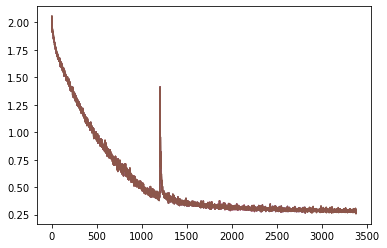

In [41]:
# Implement the training loop here
if not skip_training:
    # YOUR CODE HERE
    n_epochs = 30
    iters = 1
    optimizer = optim.Adam(gnn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(reduction='mean')
    train_loss, test_lst = [], []
    for e in range(n_epochs):
        print(f"Epoch {e}")
        for batch in trainloader:
            inputs, targets, src_ids, dst_ids = batch
            inputs, targets = inputs.to(device), targets.to(device)
            src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)
            
            optimizer.zero_grad()
            
#             print("inputs.size()", inputs.size())
#             print("src_ids.size()", src_ids.size())
#             print("dst_ids.size()", dst_ids.size())
            outputs = gnn(inputs, src_ids, dst_ids)
#             print("outputs[i,:,:].size()", outputs[0,:,:].size())
#             print("outputs[i,:,:].dtype", outputs[0,:,:].dtype)
#             print("outputs[0,0,:]", outputs[0,0,:])

            loss = 0
#             print("targets.size()", targets.size())
#             print("targets.dtype", targets.dtype)
#             print("targets[0]", targets[0])
            for i in range(gnn.n_iters):
                loss += criterion(outputs[i,:,:], targets)
            loss /= gnn.n_iters
            
            
            
            loss.backward()
            optimizer.step()
            
            iters += 1
            train_loss.append(loss.item())
            if iters % 5 == 0:
                test_metric = fraction_of_solved_puzzles(gnn, testloader)
                test_lst.append(test_metric)
                print(f"Iteration {iters}")
                print(f"Loss: {loss.item()}, solved sudokus {test_metric}")
        plt.plot(train_loss)

In [42]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(gnn, '7_gnn.pth')
else:
    gnn = GNN()
    tools.load_model(gnn, '7_gnn.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 7_gnn.pth.


## Evaluate the trained model

In [43]:
# Get graph iterations for some test puzzles
with torch.no_grad():
    inputs, targets, src_ids, dst_ids = iter(testloader).next()
    inputs, targets = inputs.to(device), targets.to(device)
    src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

    batch_size = inputs.size(0) // 81
    outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, n_nodes, 9]

    solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)
    final_solution = solution[-1].argmax(dim=3)
    print('Solved puzzles in the current mini-batch:')
    print((final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1))

Solved puzzles in the current mini-batch:
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True])


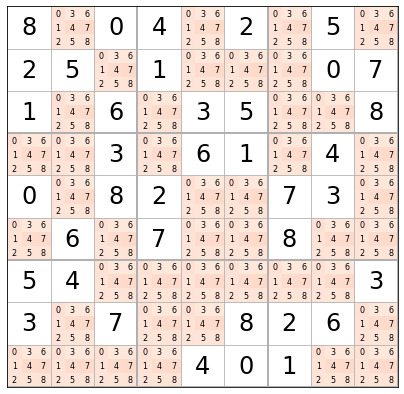

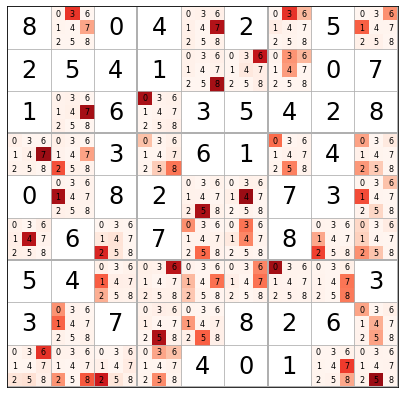

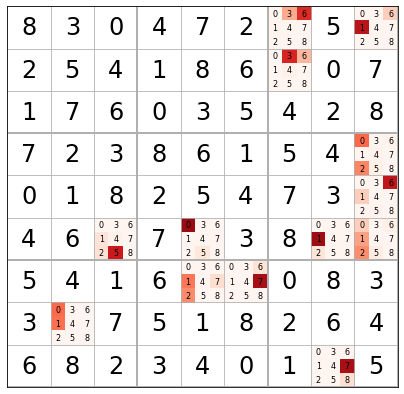

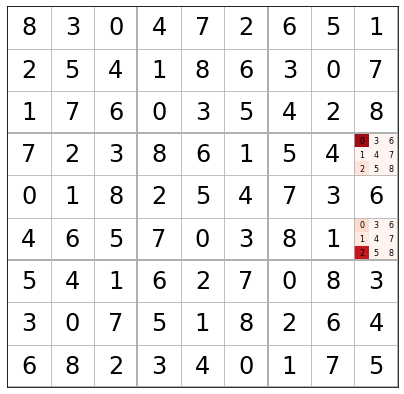

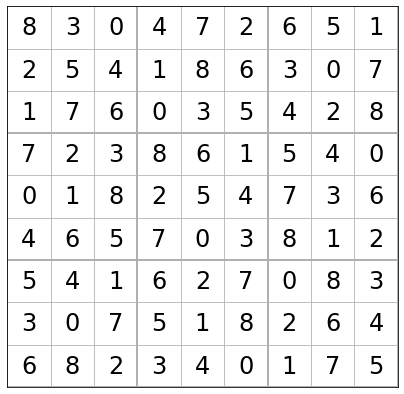

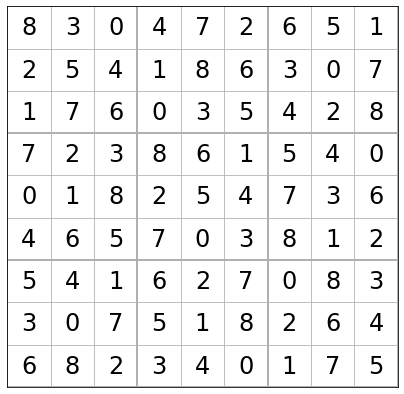

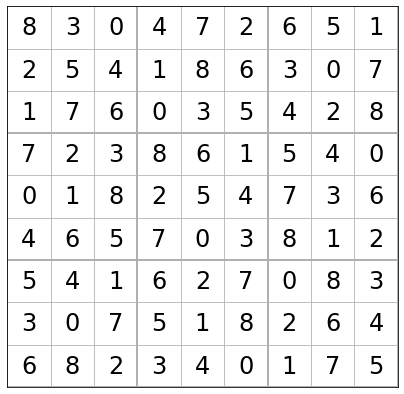

In [44]:
# Visualize graph iteration for one of the puzzles
ix = 0
for i in range(gnn.n_iters):
    tools.draw_sudoku(solution[i, 0], logits=True)

In [45]:
fraction_solved = fraction_of_solved_puzzles(gnn, testloader)
assert fraction_solved > .93, "Poor accuracy ({:.3f})".format(fraction_solved)
print('Success')

AssertionError: Poor accuracy (0.875)

<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

In this exercise, we learned how to train a simple graph neural network.